In [36]:
import itertools

import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx

import meshplot as mp
import pyvista as pv
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from src import shapes

# Define The Figure and the Morse Function

In [14]:
def get_linear_morse(vector=None):
    if vector is None:
        vector = np.random.random(4)
    vector = np.array(vector)
    def f(points):
        return points @ vector
    return f

direction = np.random.random(3)
direction /= np.linalg.norm(direction)

In [30]:
f0 = get_linear_morse([0, 1, 0])

f = lambda p: f0(p)

In [172]:
n, m = 13, 12
vertices, faces = shapes.get_halftori_bouquet(leaves=2, n=n, m=m, l0=0.8, glue=False)
vertices, faces = shapes.split_large_edges(vertices, faces, max_length=1.1)
#vertices += 0.05*np.random.normal(size=vertices.shape)

print(f'faces.shape = {faces.shape}')

face_mean_values = f(vertices[faces]).mean(axis=1)

p = mp.plot(vertices, faces, face_mean_values, shading={"wireframe": True})

faces.shape = (672, 3)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [173]:
faces_pv = np.hstack([np.full((faces.shape[0], 1), 3, dtype=faces.dtype), faces]).ravel()

mesh = pv.PolyData(vertices, faces_pv)
mesh.point_data["values"] = f(vertices)  # per-vertex scalars

p = pv.Plotter(window_size=(600, 600))
p.add_mesh(
    mesh,
    scalars="values",
    cmap="viridis",
    smooth_shading=False,   # helps show linear interpolation nicely
    show_edges=True,      # set True if you want to see triangle edges
)
p.add_scalar_bar(title="values")
p.show()

Widget(value='<iframe src="http://localhost:32995/index.html?ui=P_0x7c0a215fc190_63&reconnect=auto" class="pyv…

In [174]:
def get_next_vertices(vertex, faces, f, f_grad=None, direction_up=True):
    """
    """
    neighbourhood_faces = faces[(faces == vertex).any(axis=1)]
    if f_grad is None:
        f_grad = lambda v0, v1: abs(f(v1))
    
    neighbourhood_graph = nx.Graph()
    neighbourhood_graph.add_edges_from(neighbourhood_faces[:, [0, 1]])
    neighbourhood_graph.add_edges_from(neighbourhood_faces[:, [0, 2]])
    neighbourhood_graph.add_edges_from(neighbourhood_faces[:, [1, 2]])

    neighbourhood_vertices = np.unique(neighbourhood_faces)
    neighbourhood_values = f(neighbourhood_vertices) - f(vertex)
    if direction_up:
        forward_vertices = neighbourhood_vertices[neighbourhood_values > 0]
    else:
        forward_vertices = neighbourhood_vertices[neighbourhood_values < 0]
        
    next_vertices = [np.array(list(component)) for component in nx.connected_components(neighbourhood_graph.subgraph(forward_vertices))]
    next_vertices = [component[np.argmax(f_grad(vertex, component))] for component in next_vertices]

    return next_vertices

In [175]:
morse_function = lambda v: f(vertices[v])

gradient_functions = {
    r'df(v0, v1) = ||v_1 - v_0||': lambda v0, v1: np.linalg.norm(vertices[v1] - vertices[v0], axis=-1), 
    r'df(v0, v1) = ||v_1 - v_0||*|f(v1) - f(v0)|': lambda v0, v1: np.linalg.norm(vertices[v1] - vertices[v0], axis=-1)*abs(morse_function(v0) - morse_function(v1)), 
    r'df(v0, v1) = |f(v1) - f(v0)|/||v1 - v0||': lambda v0, v1: abs(morse_function(v0) - morse_function(v1))/np.linalg.norm(vertices[v1] - vertices[v0], axis=-1), 
    r'df(v0, v1) = -|f(v1) - f(v0)|/||v1 - v0||': lambda v0, v1: -abs(morse_function(v0) - morse_function(v1))/np.linalg.norm(vertices[v1] - vertices[v0], axis=-1)
}


In [176]:
def get_vertex_type_row(row):
    upper = row['upper_cnt']
    lower = row['lower_cnt']

    if upper + lower == 0:
        return 'isolated'
    if (upper == 1) and (lower == 1):
        return 'regular'
    if (upper == 0) and (lower == 1):
        return 'max'
    if (upper == 1) and (lower == 0):
        return 'min'
    return 'saddle'

In [177]:
gradient_dfs = dict()

for key, gradient_function in gradient_functions.items():
    df_points = pd.DataFrame({'vertex': np.unique(faces), 'pos':list (vertices)})

    df_points['upper_vertices'] = df_points['vertex'].apply(lambda vertex: get_next_vertices(vertex, faces, f=morse_function, f_grad=gradient_function, direction_up=True))
    df_points['lower_vertices'] = df_points['vertex'].apply(lambda vertex: get_next_vertices(vertex, faces, f=morse_function, f_grad=gradient_function, direction_up=False))
    df_points['upper_cnt'] = df_points['upper_vertices'].apply(len)
    df_points['lower_cnt'] = df_points['lower_vertices'].apply(len)

    df_points['type'] = df_points.apply(get_vertex_type_row, axis=1)

    gradient_dfs.update({key: df_points.copy()})

print('\n'.join([f'gradient_dfs[{key.__repr__()}].shape = {df_points.shape}' for key, df_points in gradient_dfs.items()]))

gradient_dfs['df(v0, v1) = ||v_1 - v_0||'].shape = (336, 7)
gradient_dfs['df(v0, v1) = ||v_1 - v_0||*|f(v1) - f(v0)|'].shape = (336, 7)
gradient_dfs['df(v0, v1) = |f(v1) - f(v0)|/||v1 - v0||'].shape = (336, 7)
gradient_dfs['df(v0, v1) = -|f(v1) - f(v0)|/||v1 - v0||'].shape = (336, 7)


In [178]:
pd.DataFrame({key: df['type'].value_counts() for key, df in gradient_dfs.items()}).transpose()

type,regular,saddle,min,max
"df(v0, v1) = ||v_1 - v_0||",332,2,1,1
"df(v0, v1) = ||v_1 - v_0||*|f(v1) - f(v0)|",332,2,1,1
"df(v0, v1) = |f(v1) - f(v0)|/||v1 - v0||",332,2,1,1
"df(v0, v1) = -|f(v1) - f(v0)|/||v1 - v0||",332,2,1,1


In [179]:
paths_dfs_list = []

for key, df_points in gradient_dfs.items():
    paths = []

    for saddle in df_points[df_points['type'] == 'saddle']['vertex']:
        for col_name in ['upper_vertices', 'lower_vertices']:
            for second_point in df_points.loc[saddle, col_name]:
                path = [saddle, second_point]
                while len(df_points.loc[path[-1], col_name]) == 1:
                    path.append(df_points.loc[path[-1], col_name][0])
                if len(df_points.loc[path[-1], col_name]) != 0:
                    print(f'Warning: {path[-1]} -> {df_points.loc[path[-1], col_name]}')
                paths.append(np.array(path))

    df_paths = pd.DataFrame({'path': paths})
    df_paths['start'] = df_paths['path'].apply(lambda s: s[0])
    df_paths['finish'] = df_paths['path'].apply(lambda s: s[-1])
    df_paths['direction'] = df_points.loc[df_paths['finish'].values]['type'].values#.map({'max': 'increasing', 'min': 'decreasing'}).values

    df_paths.insert(0, 'index', df_paths.index)
    df_paths.insert(0, 'gradient', key)

    paths_dfs_list.append(df_paths)
    
df_paths = pd.concat(paths_dfs_list)
df_paths = df_paths.reset_index(drop=True)
df_paths['color'] = [mcolors.to_hex(c) for c in plt.get_cmap('jet')(df_paths['index']/df_paths['index'].max())]

df_paths['line'] = df_paths['path'].apply(lambda path: vertices[path])

print(f'df_paths.shape = {df_paths.shape}')
df_paths.head()

df_paths.shape = (32, 8)


,gradient,index,path,start,finish,direction,color,line
0,"df(v0, v1) = ||v_1 - v_0||",0,"[167, 154, 144, 117, 80, 48, 18, 8, 2, 13, 16,...",167,179,max,#000080,"[[6.123233995736766e-17, -1.8000000000000003, ..."
1,"df(v0, v1) = ||v_1 - v_0||",1,"[167, 180, 190, 217, 254, 286, 314, 328, 335, ...",167,179,max,#0010ff,"[[6.123233995736766e-17, -1.8000000000000003, ..."
2,"df(v0, v1) = ||v_1 - v_0||",2,"[167, 150, 163, 140, 159, 126, 156]",167,156,min,#00a4ff,"[[6.123233995736766e-17, -1.8000000000000003, ..."
3,"df(v0, v1) = ||v_1 - v_0||",3,"[167, 151, 164, 141, 160, 127, 156]",167,156,min,#40ffb7,"[[6.123233995736766e-17, -1.8000000000000003, ..."
4,"df(v0, v1) = ||v_1 - v_0||",4,"[168, 153, 172, 143, 176, 129, 179]",168,179,max,#b7ff40,"[[6.123233995736766e-17, 1.8000000000000003, 1..."


In [180]:
vertex_type_colors_dict = {
    'min': "lime", 
    'saddle': "gold", 
    'max': 'orangered', 
    'regular': 'gray'
}

In [181]:
grad_path_graphs = {key: nx.Graph() for key in gradient_functions.keys()}
for key in grad_path_graphs.keys():
    paths = df_paths[df_paths['gradient'] == key]['path'].values
    edges = np.concatenate([np.transpose([path[1:], path[:-1]]) for path in paths])
    grad_path_graphs[key].add_edges_from(edges)

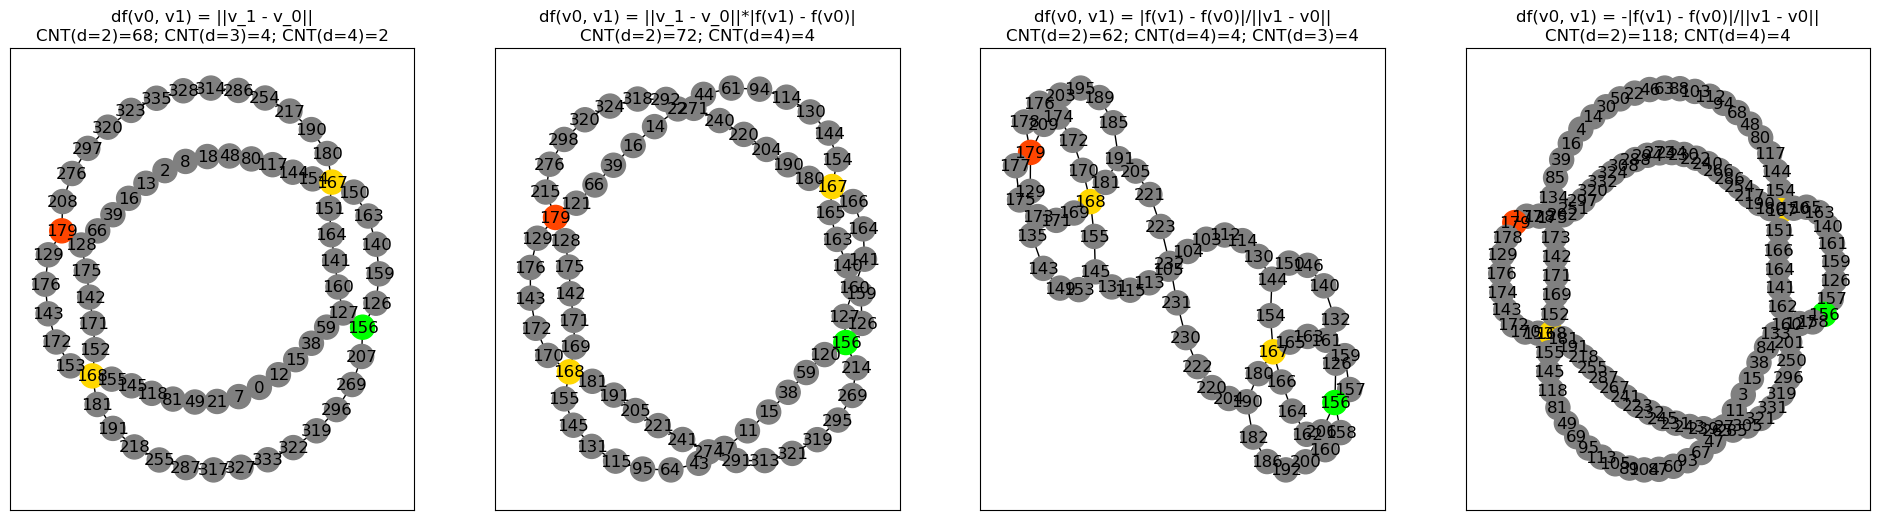

In [196]:
fig, axs = plt.subplots(1, len(grad_path_graphs), figsize=(24, 6))

for i, (key, graph) in enumerate(grad_path_graphs.items()):
    graph_is_planar = nx.is_planar(graph)
    degree_counts = dict(pd.Series(dict(graph.degree())).value_counts())
    degree_counts = '; '.join([f'CNT(d={degree})={cnt}' for degree, cnt in degree_counts.items()])

    axs[i].set_title(f'{key}\n{degree_counts}')
    pos = nx.kamada_kawai_layout(graph)
    node_color = gradient_dfs[key].loc[list(graph.nodes())]['type'].apply(lambda t: vertex_type_colors_dict[t])
    nx.draw_networkx(graph, pos=pos, node_color=node_color, ax=axs[i])

In [183]:
import pyvista as pv

p = pv.Plotter(shape=(len(gradient_functions), 2), window_size=(1200, len(gradient_functions)*500))

for i, gradient_title in enumerate(gradient_functions.keys()):
    df_points = gradient_dfs[gradient_title]
    path_lines = df_paths[df_paths['gradient'] == gradient_title]['line'].values
    path_colors = df_paths[df_paths['gradient'] == gradient_title]['color'].values

    p.subplot(i, 0)
    p.add_text(gradient_title, font_size=12)
    p.add_mesh(mesh, scalars="values", cmap="viridis", smooth_shading=False, show_edges=True)
    for type_name in ['min', 'saddle', 'max']:
        color = vertex_type_colors_dict[type_name]
        points = np.array(list(df_points[df_points['type'] == type_name]['pos'].values))
        p.add_points(points, color=color, point_size=12, render_points_as_spheres=True)
    for line in path_lines:
        p.add_mesh(pv.lines_from_points(line), color="white", line_width=4)

    p.subplot(i, 1)
    p.add_text(gradient_title, font_size=12)
    p.add_mesh(mesh, color='white', smooth_shading=False, show_edges=True)
    for type_name in ['min', 'saddle', 'max']:
        color = vertex_type_colors_dict[type_name]
        points = np.array(list(df_points[df_points['type'] == type_name]['pos'].values))
        p.add_points(points, color=color, point_size=12, render_points_as_spheres=True)
    for line, color in zip(path_lines, path_colors):
        p.add_mesh(pv.lines_from_points(line), color=color, line_width=8)

p.link_views()
p.show()


Widget(value='<iframe src="http://localhost:32995/index.html?ui=P_0x7c0a218b5810_64&reconnect=auto" class="pyv…